# Visualize dataset

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from omegaconf import OmegaConf

import event_prediction
from event_prediction.data.data_utils import download_data_from_url, extract

c:\Users\monte\code\event_prediction\.venv_nb\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

url = "https://obj.umiacs.umd.edu/eventprediction/transactions_small.tgz"  # 1k transactions
# url = "https://obj.umiacs.umd.edu/eventprediction/transactions_med.tgz"  # 1m transactions
# url = "https://obj.umiacs.umd.edu/eventprediction/transactions.tgz"  # 25m transactions
data = download_data_from_url(url)
print("Extracting...")
data = extract(data)
print("Creating dataframe...")
df = pd.read_csv(data)

print(f"Total rows: {df.shape[0]}, total columns: {df.shape[1]}")
df.head()

Extracting...
Creating dataframe...
Total rows: 1000, total columns: 16


,Unnamed: 0,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No
1,1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
2,2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
3,3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No
4,4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No


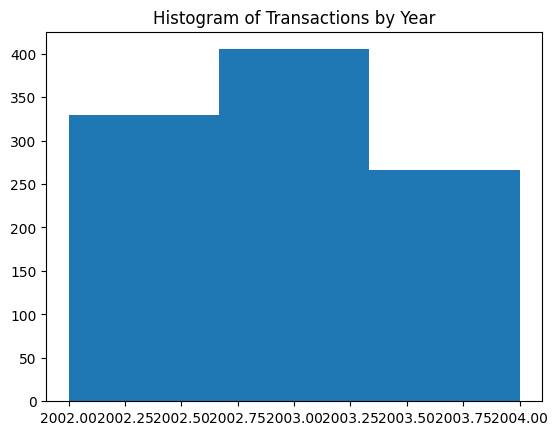

In [10]:
plt.hist(df['Year'], bins=len(df['Year'].unique()))
plt.title('Histogram of Transactions by Year')
plt.show()

In [3]:
cfg_dir = "event_prediction/config"
cfg = OmegaConf.load(f"{cfg_dir}/pre_process_data.yaml")
data_cfg = OmegaConf.load(f"{cfg_dir}/data/ibm_fraud_transaction_small.yaml")
token_cfg = OmegaConf.load(f"{cfg_dir}/tokenizer/composite.yaml")

tokenizer = event_prediction.get_tokenizer(token_cfg, data_cfg)

In [4]:

normed_data = tokenizer.normalize(df)
normed_data.head()

,User,Card,Use Chip,Merchant State,MCC,Errors?,top_mcc,top_chip,Amount,Hour,total_minutes_from_last,Is Fraud?,is_online,avg_dollar_amt,std_dollar_amt
0,0,0,SwipeTransaction,CA,5300,<NA>,5411,SwipeTransaction,8,0,0,True,False,5,5
1,0,0,SwipeTransaction,CA,5411,<NA>,5411,SwipeTransaction,2,0,1,True,False,5,5
2,0,0,SwipeTransaction,CA,5411,<NA>,5411,SwipeTransaction,7,0,7,True,False,5,5
3,0,0,SwipeTransaction,CA,5651,<NA>,5411,SwipeTransaction,8,5,5,True,False,5,5
4,0,0,SwipeTransaction,CA,5912,<NA>,5411,SwipeTransaction,7,0,5,True,False,5,5


In [5]:
wordified_data, labels = tokenizer.pretokenize(normed_data)
wordified_data.head()

0    SwipeTransaction_CA_5300_<NA>_5411_SwipeTransa...
1    SwipeTransaction_CA_5411_<NA>_5411_SwipeTransa...
2    SwipeTransaction_CA_5411_<NA>_5411_SwipeTransa...
3    SwipeTransaction_CA_5651_<NA>_5411_SwipeTransa...
4    SwipeTransaction_CA_5912_<NA>_5411_SwipeTransa...
dtype: object

In [6]:
tokenized_data = tokenizer.model(wordified_data)
tokenized_data.head()

0    SwipeTransaction_CA_5300_<NA>_5411_SwipeTransa...
1    SwipeTransaction_CA_5411_<NA>_5411_SwipeTransa...
2    SwipeTransaction_CA_5411_<NA>_5411_SwipeTransa...
3    SwipeTransaction_CA_5651_<NA>_5411_SwipeTransa...
4    SwipeTransaction_CA_5912_<NA>_5411_SwipeTransa...
dtype: object

In [7]:
post_processed_data = tokenizer.post_process(tokenized_data, labels)
post_processed_data[:5]

['User',
 'Card',
 'SwipeTransaction_CA_5300_<NA>_5411_SwipeTransaction_8_0_0_True_False_5_5',
 'SwipeTransaction_CA_5411_<NA>_5411_SwipeTransaction_2_0_1_True_False_5_5',
 'SwipeTransaction_CA_5411_<NA>_5411_SwipeTransaction_7_0_7_True_False_5_5']

In [14]:
# Optionally save a subset of the dataset if you wish.

# subset_size = 1e6
# df.head(int(subset_size)).to_csv('temp.csv', index=False)
# with tarfile.open('transactions_med.tgz', 'w:gz') as f:
#     f.add('temp.csv')